In [371]:
import re
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from itertools import chain
from collections import Counter

from reviews.config import root_dir

data_dir = root_dir / "data"
out_dir = root_dir / "output"
processed_data_dir = data_dir / "processed"
asum_output_dir = root_dir / "output" / "asum"

sns.set_style("white")

primary_color = "#ECE81A"  # 108de4ff"
secondary_color = "#C3C5C5"

# Models Comparison

In [372]:
total_df = pd.DataFrame()
for n_topics in [10, 20, 30, 50]:
    for model in ["asum", "jst"]:
        for norm in ["raw", "stemming", "lemmatization"]:
            filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}.csv"

            if not filename.exists():
                continue

            df = pd.read_csv(filename)
            df["model"] = model
            df["normalization"] = norm

            total_df = pd.concat((df, total_df))

In [373]:
total_df[total_df["model"] == "asum"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

,,f1_macro,f1_weighted,f1_micro
normalization,n_topics,,,
stemming,50,0.632539,0.84427,0.814507


In [374]:
total_df[total_df["model"] == "jst"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
stemming      10        0.563276     0.764685  0.702036
              20        0.557473     0.757249  0.692407
              30        0.558806     0.757243  0.692017
              50        0.559091     0.761021  0.697063

(0.55, 0.65)

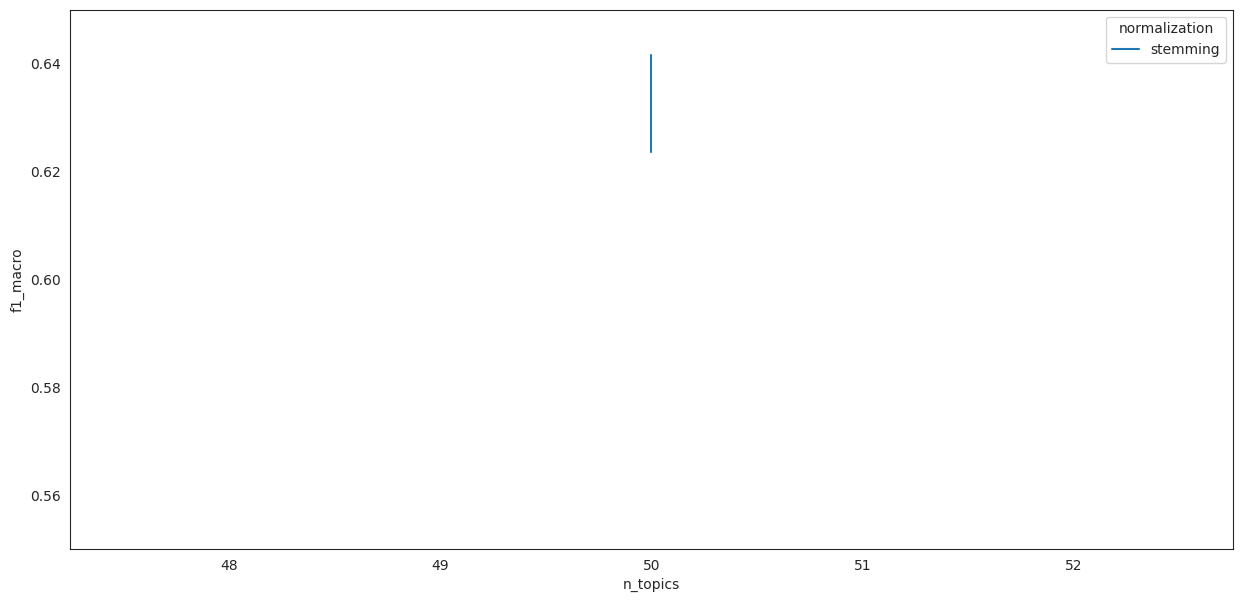

In [375]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["model"] == "asum"],
    y="f1_macro",
    x="n_topics",
    hue="normalization",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.55, 0.65])

(0.5, 0.65)

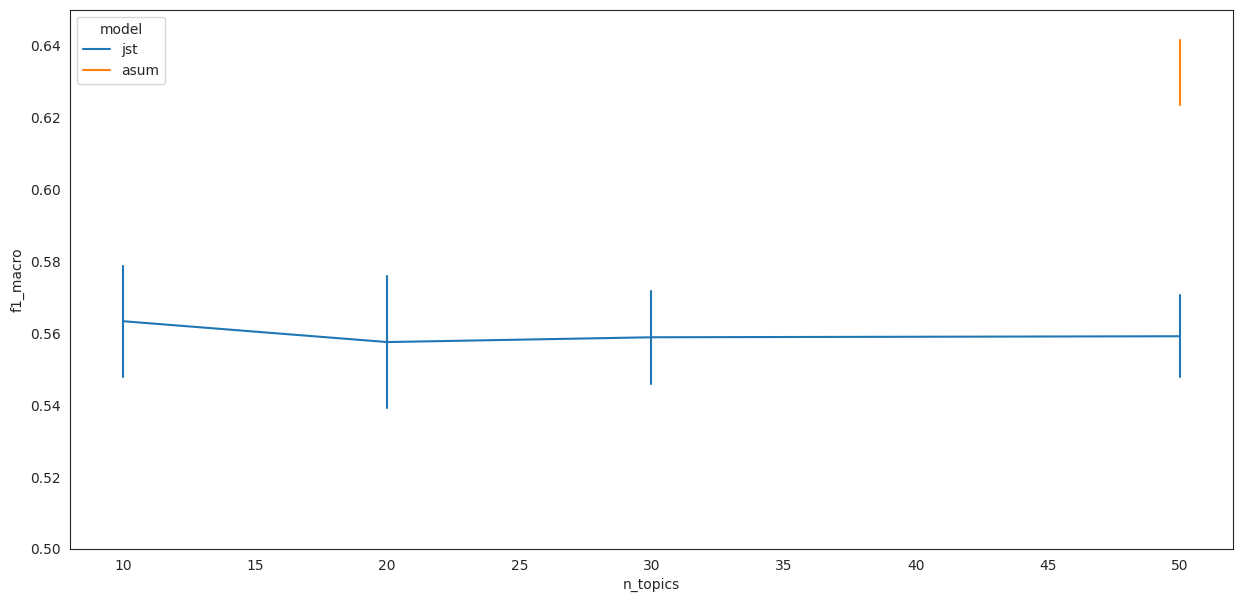

In [376]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["normalization"] == "stemming"],
    y="f1_macro",
    x="n_topics",
    hue="model",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.5, 0.65])

## Split by Commas and Conjunctions

In [377]:
total_df = pd.DataFrame()
n_topics = 50
model = "asum"
norm = "stemming"
for extra in ["", "_conj", "_comma"]:
    filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}{extra}.csv"

    if not filename.exists():
        continue

    df = pd.read_csv(filename)
    df["extra"] = "stemming" if extra == "" else extra.replace("_", "")

    total_df = pd.concat((df, total_df))
total_df

,Unnamed: 0,run,n_topics,f1_macro,f1_weighted,f1_micro,extra
0,0,0,50,0.609326,0.828343,0.792396,conj
1,1,1,50,0.620142,0.833890,0.799475,conj
2,2,2,50,0.604614,0.825127,0.787982,conj
3,3,3,50,0.622586,0.835038,0.800898,conj
4,4,4,50,0.614391,0.835558,0.803525,conj
5,5,5,50,0.603964,0.827490,0.792068,conj
6,6,6,50,0.614266,0.828762,0.792104,conj
7,7,7,50,0.614358,0.834184,0.801189,conj
8,8,8,50,0.624325,0.839479,0.808049,conj
9,9,9,50,0.618075,0.834241,0.800496,conj


<AxesSubplot: xlabel='f1_macro', ylabel='extra'>

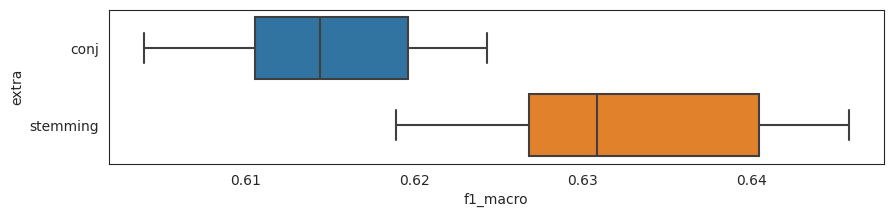

In [378]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(total_df, y="extra", x="f1_macro", ax=ax)

In [379]:
total_df.groupby("extra")[["f1_macro", "f1_weighted"]].mean()

,f1_macro,f1_weighted
extra,,
conj,0.614605,0.832211
stemming,0.632539,0.844270


# ASPECT BASED SENTIMENT ANALYSIS (ASUM)

In [380]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary
EXTRA = ""  # _conj

In [381]:
n_runs = 10
n_topics = 50
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

# Read Reviews Data

In [382]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}{EXTRA}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.54%
Empty Reviews: 0.05%


In [383]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

## PI = documents x sentiment

In [384]:
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

## PHI = vocabulary x senti aspects

In [385]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)

## THETA = documents x senti aspects


In [386]:
def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

In [387]:
# reviews with equal probabilities for each topic
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  162


In [388]:
(f_theta_df > T).sum(axis=1).describe()

count    28821.000000
mean         1.619722
std          0.913355
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [389]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0               [S0-T25, S0-T39]
1        [S0-T3, S0-T17, S1-T24]
2               [S0-T44, S1-T11]
3                       [S0-T41]
4                       [S1-T26]
                  ...           
28978            [S0-T2, S0-T19]
28979            [S1-T3, S1-T29]
28980                    [S0-T8]
28981                   [S1-T36]
28982                   [S0-T23]
Length: 28983, dtype: object

In [390]:
one_token_idx = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 2)
topics[one_token_idx]

20       [S1-T36, S1-T45]
37               [S1-T36]
54               [S0-T20]
70               [S0-T37]
82               [S0-T21]
               ...       
28938            [S0-T46]
28945            [S1-T36]
28968      [S0-T9, S1-T7]
28975            [S1-T11]
28976            [S0-T36]
Length: 1724, dtype: object

In [391]:
reviews_df.loc[20]

asin                                                      B00FPIMJEW
overall                                                            4
reviewerID                                            A2G5UWIC85104M
summary                                  It does what it's made for.
text                                         It works.  No problems.
timestamp                                        2015-10-04 00:00:00
vote                                                               0
brand                                                        inateck
category                                              I/O Port Cards
description        Due to frequently updated drivers, please down...
imageURLHighRes    https://images-na.ssl-images-amazon.com/images...
price                                                           2.54
title              Inateck PCI-E to USB 3.0 (5 Ports) PCI Express...
tokens                                       [[work], [not_problem]]
Name: 20, dtype: object

In [392]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
# reviews_df.to_json(asum_output_dir / "topics.json", orient="records")
#reviews_df["topics"]

## ProbWords

In [393]:
prob_words_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")
columns = prob_words_df.columns.map(map_topic_sentiment)

In [394]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    if match is None:
        print(text)
    word, weight = match.groups()
    return word, float(weight)


def plot_prob_words():
    n_top_words = 20
    total_df = pd.DataFrame()

    fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(50, 50))
    for idx, item in enumerate(columns):
        if item is None:
            continue

        ax = axes[
            int(int(item["topic"] / 10) * 2 + item["sentiment"]),
            int(item["topic"] % 10),
        ]
        words = prob_words_df[item["colname"]][:n_top_words]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        w = weights.copy()
        w["colname"] = item["colname"]
        total_df = pd.concat((total_df, w))

        ax.barh(weights["names"], weights["weights"], height=0.5)
        ax.set_title(item["colname"])

        ax.set_xlabel(f"Topic {item['topic'] + 1}")
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

    fig.tight_layout()

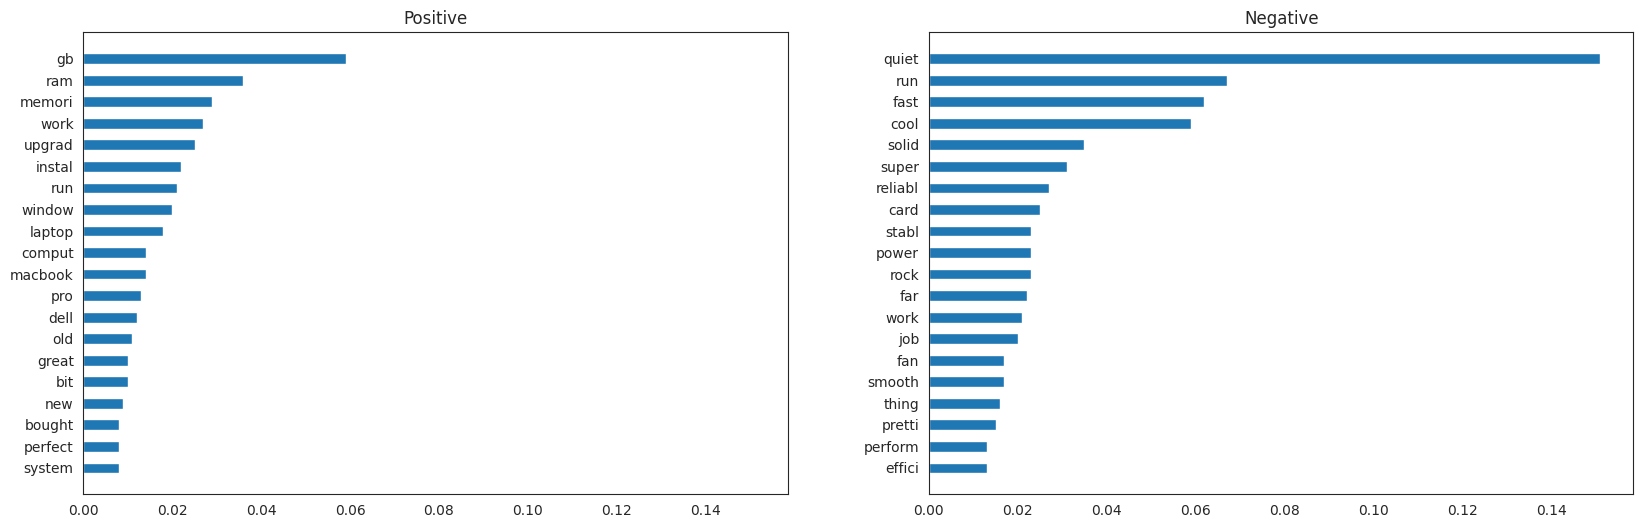

In [395]:
def show_topic(topic, n=20):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    axes = axes.flatten()

    for s in range(2):
        words = prob_words_df[f"S{s}-{topic}"][:n]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        axes[s].barh(weights["names"], weights["weights"], height=0.5)
        axes[s].set_title("Positive" if s == 0 else "Negative")


def print_examples(topic, k=5):
    ddf = reviews_df.copy()
    ddf["topics"] = ddf["topics"].apply(lambda x: set([y["colname"] for y in x]))

    pos_examples = pd.Series(
        [row["tokens"] for i, row in ddf.iterrows() if f"S0-{topic}" in row["topics"]]
    ).sample(k)
    neg_examples = pd.Series(
        [row["tokens"] for i, row in ddf.iterrows() if f"S1-{topic}" in row["topics"]]
    ).sample(k)

    print(
        "Positive ---------------------------------------------------------------------------------\n"
    )
    [print(">----------\n", ex) for ex in pos_examples]

    print(
        "\nNegative ---------------------------------------------------------------------------------"
    )
    [print(">----------\n", ex) for ex in neg_examples]


topic_mapping = {
    "T0": "psu",
    "T1": "time",
    "T2": "delivery",
    "T3": "cooling system",
    "T4": "cooling system",
    "T5": "performance",
    "T6": "memory",
    "T7": "satisfaction/recommanded",
    "T8": "psu",
    "T9": "price",
    "T10": "pc", # mac, macbook, imac
    "T11": "video",
    "T12": "performance",
    "T13": "?",
    "T14": "buy", # purchase
    "T15": "cooling system", # (air flow)
    "T16": "cooling system", # (temp)
    "T17": "overclocking",
    "T18": "satisfaction/recommanded",
    "T19": "installation",
    "T20": "satisfaction/recommanded",
    "T21": "buy", # or satisfaction/recommanded
    "T22": "sound",
    "T23": "psu",
    "T24": "cooling system", # (air flow)
    "T25": "quality",
    "T26": "satisfaction/recommanded", # quality
    "T27": "delivery",
    "T28": "aesthetic",
    "T29": "performance", # gaming
    "T30": "installation",
    "T31": "pc", # (pc build / replacement / upgrade)
    "T32": "storage connectivity",
    "T33": "processor",
    "T34": "upgrade",
    "T35": "satisfaction/recommanded",
    "T36": "motherboard",
    "T37": "?",
    "T38": "cooling system",  # (air flow)
    "T39": "installation",
    "T40": "?",
    "T41": "motherboard",
    "T42": "cooling system",
    "T43": "optical disc",
    "T44": "memory",
    "T45": "temperature", # cooling
    "T46": "satisfaction/recommanded",
    "T47": "satisfaction/recommanded",
    "T48": "motherboard",
    "T49": "memory",
}

topic = "T49"
show_topic(topic, n=20)

In [396]:
print_examples(topic)

Positive ---------------------------------------------------------------------------------

>----------
 [['order', 'memori', 'use', 'older', 'core', 'duo', 'laptop', 'upgrad', 'gb', 'ssd', 'wine', 'pro', 'memori', 'work', 'perfect', 'old', 'laptop', 'scream']]
>----------
 [['sped', 'mid', 'macbook']]
>----------
 [['pop', 'gb', 'chip', 'new', 'asus', 'njq', 'work', 'great'], ['window', 'recogn', 'immedi'], ['total', 'gb'], ['not_buy', 'not_gb', 'not_chip'], ['ran', 'memtest', 'found', 'zero', 'problem'], ['nice', 'thing', 'work', 'easili', 'new', 'comput'], ['note', 'current', 'non', 'extrem', 'version', 'intel', 'core', 'cpu', 'laptop', 'support', 'max', 'gb', 'accord', 'intel', 'websit'], ['peopl', 'work', 'not_expect', 'not_intel', 'not_explain', 'not_time'], ['check', 'cpu', 'ark', 'dot', 'intel', 'dot', 'com', 'updat', 'bought', 'instal', 'gb', 'stick'], ['work', 'great']]
>----------
 [['truck', 'month']]
>----------
 [['mac', 'need']]

Negative --------------------------------

In [397]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
words_probs = phi_df.set_index("Unnamed: 0")
tot_probs = words_probs.sum(axis=1)

pos_t = [f"S0-T{t}" for t in range(n_topics)]
pos_probs = words_probs[pos_t]
pos_max_probs = pos_probs.sum(axis=1).max()

neg_t = [f"S1-T{t}" for t in range(n_topics)]
neg_probs = words_probs[neg_t]
neg_max_probs = neg_probs.sum(axis=1).max()

print(pos_max_probs, neg_max_probs)


#pos_probs.sum(axis=1) / pos_max_probs
probs = pd.DataFrame({
    "pos": pos_probs.sum(axis=1) / tot_probs,
    "neg": neg_probs.sum(axis=1) / tot_probs
})


1.9340590061931133 1.1813846392504488


### Test

In [398]:
from reviews.utils import flat_sentence_tokens
from reviews.preprocess import ss

test_reviews_df = pd.read_json(processed_data_dir / f"reviews_text_lemmatization.json.gz")

tokens = flat_sentence_tokens(test_reviews_df["tokens"])
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))

vocabs = set(vocabulary.keys())
vocabs = set([v.replace("not_", "") for v in vocabs])

In [399]:
from nltk.tag import pos_tag

In [400]:
adjs = set([w for v in vocabs for w, t in pos_tag([str(v)]) if t.startswith("J")])
adjs = set([ss.stem(w) for w in adjs])
adjs = adjs.union([f"not_{w}" for w in adjs])
adjs = adjs.intersection(set([str(v) for v in probs.index.values]))

In [401]:
probs.loc[list(adjs)]

,pos,neg
Unnamed: 0,,
predict,0.328464,0.671536
not_ambiti,0.570785,0.429215
substanti,0.903665,0.096335
not_unforeseen,0.017711,0.982289
ceram,0.964990,0.035010
...,...,...
not_esthet,0.196139,0.803861
uncomfort,0.890502,0.109498
not_posit,0.328818,0.671182


## Sentiment

In [402]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

fig = px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
    width=400,
    height=400,
)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment.png")
fig

### Sentiment Over Time

In [403]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
    width=2000,
    height=500,
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment_over_time.png")
fig

## Topics

In [404]:
count = Counter()
for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = (
    topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
)
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=[secondary_color],
    category_orders=dict(topic=order),
    width=1000,
    height=600,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig1.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig1.write_image("../output/topics.png")

print("TODO: count as 1 the aggregated topics!")
fig1

TODO: count as 1 the aggregated topics!


In [405]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    width=1000,
    height=600,
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig2.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig2.write_image("../output/topics_sentiment.png")
fig2

In [406]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# global sentiment
sentiment_df = competitors_df.groupby("brand")["sentiment"].value_counts()
sentiment_df_perc = sentiment_df / sentiment_df.groupby("brand").sum()
sentiment_df_perc = (
    pd.DataFrame(sentiment_df_perc * 100)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)

fig2 = px.bar(
    sentiment_df_perc,
    x="count",
    y="brand",
    color="sentiment",
    barmode="relative",
    category_orders=dict(brand=["corsair", *competitors]),
)
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_xaxes(showgrid=False, title_text="", showticklabels=False)
fig2.update_layout(margin=dict(l=0, t=0, r=0, b=0))
fig2

In [407]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# positive sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "positive"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig3 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig3.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig3.update_yaxes(showgrid=False, title_text="# Reviews")
fig3.update_layout({"margin": dict(l=0, r=0, b=0)})
fig3

In [408]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# negative sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "negative"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig4 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig4.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig4.update_yaxes(showgrid=False, title_text="# Reviews")
fig4.update_layout({"margin": dict(l=0, r=0, b=0)})
fig4

In [409]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 25, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 3, 'colname': 'S0-T...
2        [{'sentiment': 0, 'topic': 44, 'colname': 'S0-...
3        [{'sentiment': 0, 'topic': 41, 'colname': 'S0-...
4        [{'sentiment': 1, 'topic': 26, 'colname': 'S1-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 2, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 3, 'colname': 'S1-T...
28980    [{'sentiment': 0, 'topic': 8, 'colname': 'S0-T...
28981    [{'sentiment': 1, 'topic': 36, 'colname': 'S1-...
28982    [{'sentiment': 0, 'topic': 23, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [410]:
def map_topics(x):
    [y.update({"name": topic_mapping[f"T{y['topic']}"]}) for y in x]
    return x


map_topics(reviews_df["topics"][0])

[{'sentiment': 0, 'topic': 25, 'colname': 'S0-T25', 'name': 'quality'},
 {'sentiment': 0, 'topic': 39, 'colname': 'S0-T39', 'name': 'installation'}]

In [411]:
reviews_df["topics"] = reviews_df["topics"].apply(map_topics)

In [412]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 25, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 3, 'colname': 'S0-T...
2        [{'sentiment': 0, 'topic': 44, 'colname': 'S0-...
3        [{'sentiment': 0, 'topic': 41, 'colname': 'S0-...
4        [{'sentiment': 1, 'topic': 26, 'colname': 'S1-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 2, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 3, 'colname': 'S1-T...
28980    [{'sentiment': 0, 'topic': 8, 'colname': 'S0-T...
28981    [{'sentiment': 1, 'topic': 36, 'colname': 'S1-...
28982    [{'sentiment': 0, 'topic': 23, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [413]:
reviews_df.to_json(asum_output_dir / "reviews_sentiments.json.gz", orient="records")

# ASPECT BASED SENTIMENT ANALYSIS (JST)

In [414]:
NORM = "stemming"
FIELD = "text"

n_runs = 10
n_topics = 50
iterations = 1000

alpha = -1
beta = -1
gamma = -1

# Read Reviews Data

In [415]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.54%
Empty Reviews: 0.05%


In [416]:
# columns name
columns_name = []

for x in range(2):
    for y in range(n_topics):
        columns_name.append("S" + str(x) + "-T" + str(y))

## PHI = vocabulary x senti aspects

In [417]:
# prepare phi file for analysis
with open(out_dir / "jst" / "final.phi") as f:
    lines = f.readlines()

    phi = {}
    tmp = ""
    for i, line in enumerate(lines):
        if i % 2 != 0:
            phi[tmp] = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
        else:
            tmp = line.strip()

phi_df = pd.DataFrame(phi)
phi_df.columns = columns_name
phi_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.013536,0.000002,0.000002,0.009105,0.007058,0.018535,0.000002,0.076919,0.015572,0.006026,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000001,0.000002,0.000002,0.000801,0.000001,0.000002,0.009759,0.139185,0.017451,0.000001,...,0.011107,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.005046,0.004171
2,0.000001,0.000002,0.000002,0.011106,0.000589,0.000002,0.019516,0.028327,0.000003,0.004645,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000001,0.000002,0.040987,0.000001,0.000001,0.042543,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.018339,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
4,0.000001,0.000002,0.000002,0.008005,0.005882,0.000002,0.000190,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.003650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20358,0.000001,0.000002,0.000002,0.000001,0.000001,0.000213,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20359,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20360,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001


## PI = documents x sentiment

In [418]:
# prepare pi file for analysis
pi_df = pd.read_csv(out_dir / "jst" / "final.pi", sep=" ", header=None)
pi_df.drop([0, 1, 4], axis=1, inplace=True)
pi_df.columns = ["S0", "S1"]
pi_df

,S0,S1
0,0.745614,0.254386
1,0.028090,0.971910
2,0.061905,0.938095
3,0.119048,0.880952
4,0.722222,0.277778
...,...,...
28978,0.932432,0.067568
28979,0.417808,0.582192
28980,0.722222,0.277778
28981,0.722222,0.277778


## THETA = documents x senti aspects

In [419]:
with open(out_dir / "jst" / "final.theta") as f:
    lines = f.readlines()

    theta = []
    tmp = []
    for i, line in enumerate(lines):
        if i % 3 != 0:
            values = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
            tmp.extend(values)
        else:
            if tmp:
                theta.append(tmp)
                tmp = []

theta_df = pd.DataFrame(theta, columns=columns_name)
theta_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.377647,0.001176,0.001176,...,0.003448,0.003448,0.003448,0.003448,0.279310,0.003448,0.003448,0.003448,0.003448,0.003448
1,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.000508,0.000508,0.000508,0.000508,0.000508,0.447208,0.000508,0.244162,0.000508,0.000508
3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
4,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.080198,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
28978,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
28979,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.526230,0.001639,0.001639,...,0.001176,0.001176,0.001176,0.095294,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176
28980,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000


In [420]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  31


In [421]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0        [S0-T7, S0-T42, S1-T5, S1-T44]
1                      [S1-T28, S1-T39]
2              [S0-T19, S1-T45, S1-T47]
3                       [S1-T7, S1-T29]
4                              [S0-T39]
                      ...              
28977          [S0-T30, S0-T41, S1-T11]
28978                  [S0-T24, S0-T38]
28979    [S0-T7, S0-T18, S1-T8, S1-T12]
28980                          [S0-T42]
28981                           [S0-T6]
Length: 28982, dtype: object

In [422]:
(f_theta_df > T).sum(axis=1).describe()

count    28951.000000
mean         3.031018
std          1.424995
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
dtype: float64

In [423]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
1        [{'sentiment': 1, 'topic': 28, 'colname': 'S1-...
2        [{'sentiment': 0, 'topic': 19, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 7, 'colname': 'S1-T...
4        [{'sentiment': 0, 'topic': 39, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 24, 'colname': 'S0-...
28979    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28980    [{'sentiment': 0, 'topic': 42, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 6, 'colname': 'S0-T...
28982                                                  NaN
Name: topics, Length: 28983, dtype: object

In [424]:
for x in reviews_df["topics"]:
    if type(x) is float:
        print(x)

nan


## Sentiment

In [425]:
doc_sentiment = pi_df.idxmax(axis=1).map(
    lambda x: "positive" if x == "S0" else "negative"
)
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

# Sentiment Over Time

In [426]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics

In [427]:
count = Counter()
for x in reviews_df["topics"].values:
    if type(x) is float:
        print(x)
        continue
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
# topics_count["topic"] = topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=["#108de4"],
    category_orders=dict(topic=order),
    height=1000,
    width=1200,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})
fig1

nan


In [428]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    if type(t) is float:
        print(t)
        continue

    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

# pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

# neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

nan
